# Наилучшее сопоставление $H_{\alpha}$ & $Q_{eff}$

In [1]:
import os
import numpy as np

%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [13]:
Qeff_min = np.load('./data/Qeff_min.npy')
Qeff_max = np.load('./data/Qeff_max.npy')
Qg = np.load('./data/Qg.npy')
H_alpha = np.load('./data/H_alpha.npy')
dist_kpc = np.load('./data/dist_kpc.npy')
sigma_s = np.load('./data/sigma_s.npy')

Text(0.5, 1.0, '$Q_{eff}^{max}$')

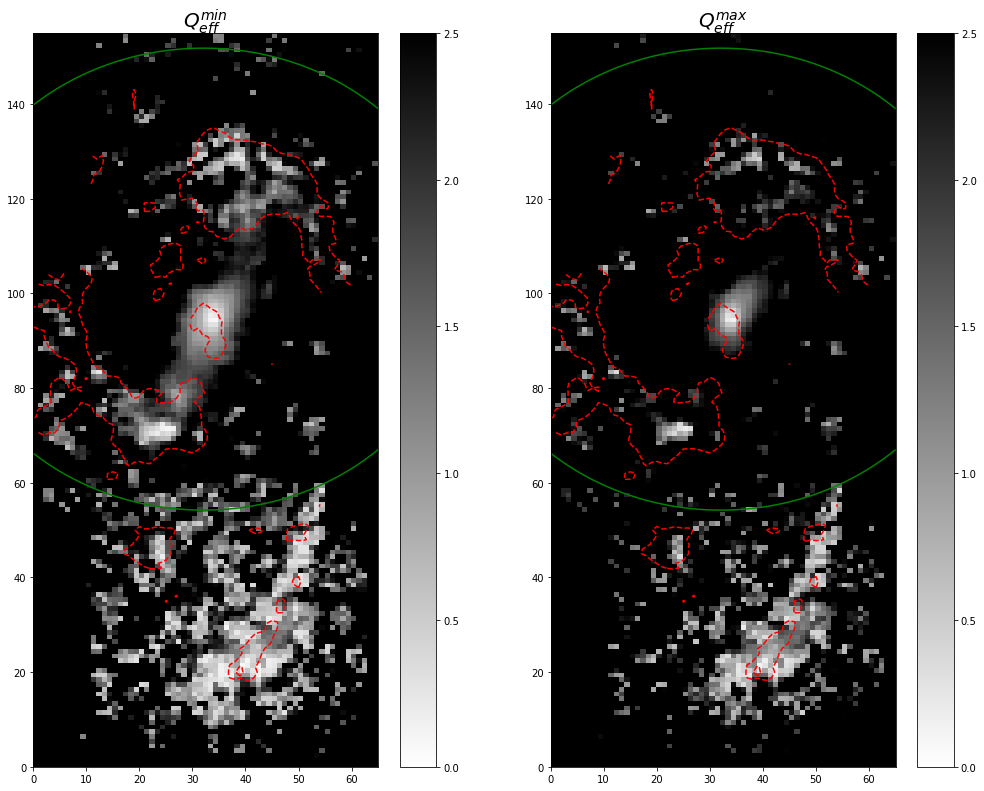

In [28]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, dist_kpc, levels=[0,5], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=2.5)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, dist_kpc, levels=[0,5], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=2.5)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)


вне 5 кпк всё не очень хорошо, попробуем при нашем статистическом исследовании отбросить всё, что находится вне этого круга и посмотрим, что из этого выйдет

## $\chi^2$

In [10]:
def chisqg(ydata,ymod,sd=None):   
    if sd==None:  
        chisq=numpy.sum((ydata-ymod)**2)  
    else:  
        chisq=numpy.sum( ((ydata-ymod)/sd)**2 )  
    return chisq  


Text(0.5, 1.0, '$Q_{max}$')

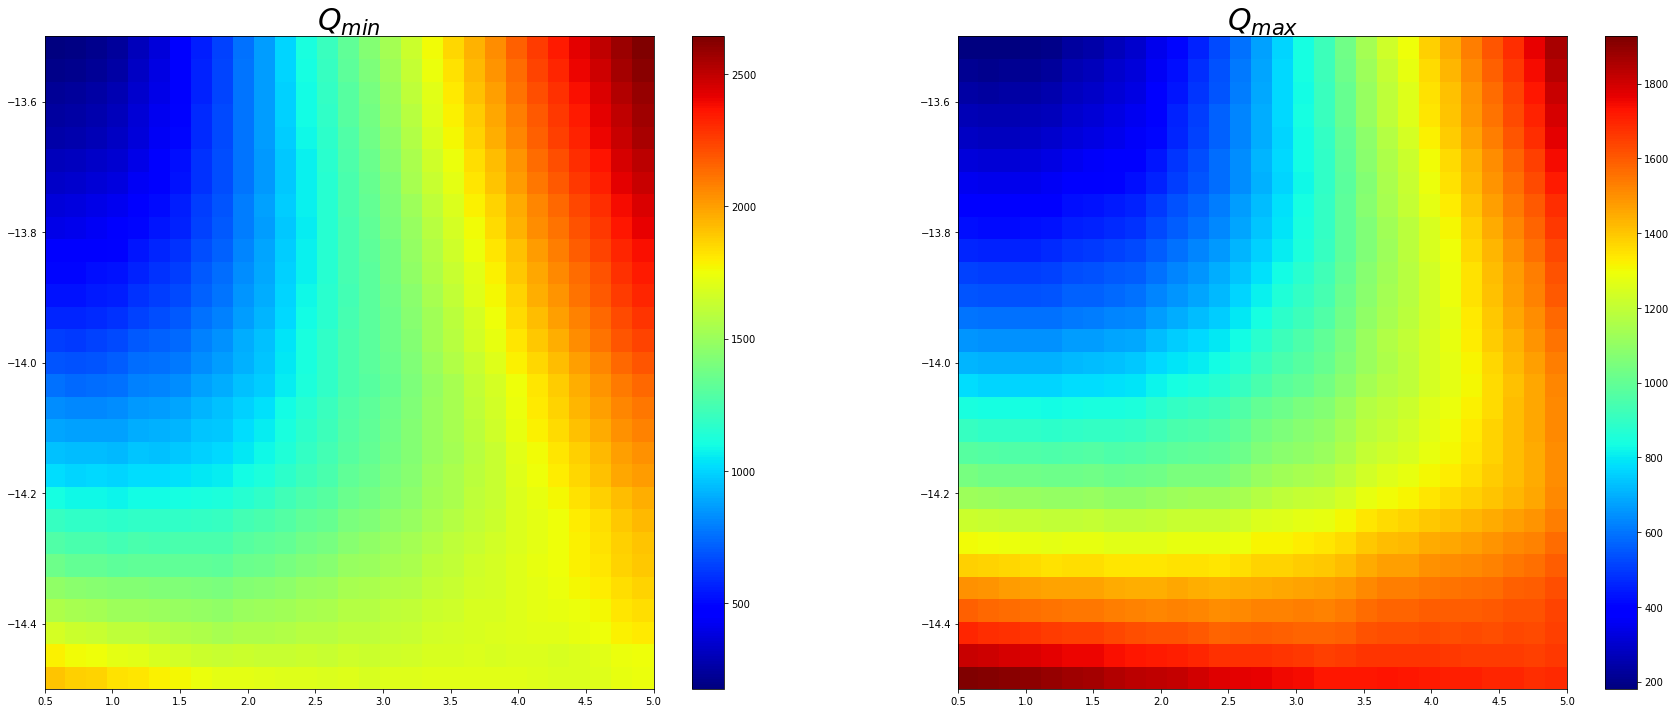

In [25]:
fig = plt.figure(figsize=[30, 12])

plt.subplot(1,2,1)
corr_coeffs = np.zeros((30,30))
for i, qlim in enumerate(np.linspace(0.5, 5., 30)):
    for j, hlim in enumerate(np.linspace(-14.5, -13.5, 30)):
        mask = (sigma_s != 0.) & (dist_kpc < 5.)
        corr_coeffs[j][i] = chisqg(np.array([1 if l < qlim else 0 for l in Qeff_min[mask].ravel()]), 
                                   np.array([1 if l > hlim else 0 for l in np.log10(H_alpha)[mask].ravel()]))
        
xx, yy = np.meshgrid(np.linspace(0.5, 5., 30), np.linspace(-14.5, -13.5, 30))
quadmesh = plt.pcolormesh(xx, yy, corr_coeffs, cmap='jet')
# quadmesh.set_clim(vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title(r'$Q_{min}$', fontsize=30)

plt.subplot(1,2,2)
corr_coeffs = np.zeros((30,30))
for i, qlim in enumerate(np.linspace(0.5, 5., 30)):
    for j, hlim in enumerate(np.linspace(-14.5, -13.5, 30)):
        mask = (sigma_s != 0.) & (dist_kpc < 5.)
        corr_coeffs[j][i] = chisqg(np.array([1 if l < qlim else 0 for l in Qeff_max[mask].ravel()]), 
                                   np.array([1 if l > hlim else 0 for l in np.log10(H_alpha)[mask].ravel()]))
        
xx, yy = np.meshgrid(np.linspace(0.5, 5., 30), np.linspace(-14.5, -13.5, 30))
quadmesh = plt.pcolormesh(xx, yy, corr_coeffs, cmap='jet')
# quadmesh.set_clim(vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title(r'$Q_{max}$', fontsize=30)

